In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
import torch.utils.data as Data
import torchvision.transforms as T
from glob import glob
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline

In [2]:
class Parser():
    #hyperparameters
    def __init__(self):
        #image setting
        self.input_width=64
        self.input_height=64
        self.local_input_width=32
        self.local_input_height=32
        self.input_channel=3
        self.input_dim=100
        
        #Training settings
        self.continue_training=False
        self.data='./'
        self.batch_size=128
        self.train_step=500000#400
        self.Tc=90000
        self.Td=10000
        self.learning_rate=0.001
        self.momentum=0.5
        self.show_freq=100 # How many iteration will show a example
        self.save_freq=1000
        
        #set alpha to 1 to give more weights to the discriminator loss
        self.alpha=0.004
        self.margin = 5
        self.img_path='./'
        self.model_path='./Pytorch_Model/'
        self.graph_path='./graphs/'
        self.images_path='./images/'
        
args = Parser() 

# Used for showing images
img_fn = transforms.Compose([transforms.ToPILImage()])
# Resizing the input images
tran_fn = transforms.Compose([transforms.transforms.Resize((64,64)),
                              transforms.ToTensor()])  
# For showing images in training folder
show_data_fn = transforms.Compose([transforms.Resize((args.input_height,args.input_width))])

In [3]:
class CelebADataset(Data.Dataset):
    def __init__(self, root, tran_fn , mode='train', args=None):
        
        self.transform = tran_fn
        self.files = sorted(glob('%s/*.jpg' % root))
        self.files = self.files[:-2000] if mode == 'train' else self.files[-2000:]

    def __getitem__(self, index):
        
        filepath = self.files[index % len(self.files)]
        filename = filepath.split('/')[-1]
        img = self.transform(Image.open(filepath))
        orig_img = img
        perturbed_imgs, mask, coord, pad_size = self.block_patch(img,args.margin)
        assert mask.shape == (3,args.input_height,args.input_width)
        mask = -(mask - 1)
        perturbed_imgs += mask*(perturbed_imgs.mean(1,keepdim=True).mean(1,keepdim=True))
        
        return orig_img, perturbed_imgs, mask, coord, pad_size

    def __len__(self):
        return len(self.files)
    
    def block_patch(self,input, margin=5):
        shape = list(input.shape)
        pad_size = torch.FloatTensor(2).uniform_(15, 26).type(torch.IntTensor) # (H,W)
        patch = torch.zeros((shape[0],pad_size[0],pad_size[1])) #(C,H,W)
        h_ = torch.FloatTensor(1).uniform_(margin, shape[1]-pad_size[0]-margin).type(torch.IntTensor)[0]
        w_ = torch.FloatTensor(1).uniform_(margin, shape[2]-pad_size[1]-margin).type(torch.IntTensor)[0]
        padding = (w_, h_, shape[2]-w_-pad_size[1], shape[1]-h_-pad_size[0])
        pad_fn = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Pad((padding), fill=(255,255,255)),
                                     transforms.ToTensor()
                                    ])
        padded = pad_fn(patch)
        coord = h_,w_
        res = input*padded
        return res, padded, coord, pad_size
    
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

In [4]:
# Prepare data

training_set = CelebADataset('./img_align_celeba/', tran_fn, mode = 'train', args = args)
training_loader = DataLoader(training_set, batch_size=args.batch_size, shuffle = True)


In [5]:
# The main Network
class Network(nn.Module):
    
    def __init__(self,args):
        super(Network, self).__init__()
        self.alpha = args.alpha
        # The paper may not use the L_bn4 and G_bn5
        self.completion= nn.Sequential(OrderedDict([
                                                    ('C_conv1', nn.Conv2d(3,64,5,1,2)),
                                                    ('C_bn1', nn.BatchNorm2d(64)),
                                                    ('C_relu1', nn.ReLU()),
                                                    ('C_conv2', nn.Conv2d(64,128,3,2,1)),
                                                    ('C_bn2', nn.BatchNorm2d(128)),
                                                    ('C_relu2', nn.ReLU()),
                                                    ('C_conv3', nn.Conv2d(128,128,3,1,1)),
                                                    ('C_bn3', nn.BatchNorm2d(128)),
                                                    ('C_relu3', nn.ReLU()),
                                                    ('C_conv4', nn.Conv2d(128,256,3,2,1)),
                                                    ('C_bn4', nn.BatchNorm2d(256)),
                                                    ('C_relu4', nn.ReLU()),
                                                    ('C_conv5', nn.Conv2d(256,256,3,1,1)),
                                                    ('C_bn5', nn.BatchNorm2d(256)),
                                                    ('C_relu5', nn.ReLU()),
                                                    ('C_conv6', nn.Conv2d(256,256,3,1,1)),
                                                    ('C_bn6', nn.BatchNorm2d(256)),
                                                    ('C_relu6', nn.ReLU()),
                                                    ('C_dilated_conv1',nn.Conv2d(256,256,3,1,2,dilation=2)),
                                                    ('C_dilated_bn1', nn.BatchNorm2d(256)),
                                                    ('C_dilated_relu1', nn.ReLU()),
                                                    ('C_dilated_conv2',nn.Conv2d(256,256,3,1,4,dilation=4)),
                                                    ('C_dilated_bn2', nn.BatchNorm2d(256)),
                                                    ('C_dilated_relu2', nn.ReLU()),
                                                    ('C_dilated_conv3',nn.Conv2d(256,256,3,1,8,dilation=8)),
                                                    ('C_dilated_bn3', nn.BatchNorm2d(256)),
                                                    ('C_dilated_relu3', nn.ReLU()),
                                                    ('C_dilated_conv4',nn.Conv2d(256,256,3,1,16,dilation=16)),
                                                    ('C_dilated_bn4', nn.BatchNorm2d(256)),
                                                    ('C_dilated_relu4', nn.ReLU()),
                                                    ('C_conv7', nn.Conv2d(256,256,3,1,1)),
                                                    ('C_bn7', nn.BatchNorm2d(256)),
                                                    ('C_relu7', nn.ReLU()),
                                                    ('C_conv8', nn.Conv2d(256,256,3,1,1)),
                                                    ('C_bn8', nn.BatchNorm2d(256)),
                                                    ('C_relu8', nn.ReLU()),
                                                    ('C_deconv1', nn.ConvTranspose2d(256,128,4,2,1)),
                                                    ('C_deconv_bn1', nn.BatchNorm2d(128)),
                                                    ('C_deconv_relu1', nn.ReLU()),
                                                    ('C_conv9', nn.Conv2d(128,128,3,1,1)),
                                                    ('C_bn9', nn.BatchNorm2d(128)),
                                                    ('C_relu9', nn.ReLU()),
                                                    ('C_deconv2', nn.ConvTranspose2d(128,64,4,2,1)),
                                                    ('C_deconv_bn2', nn.BatchNorm2d(64)),
                                                    ('C_deconv_relu2', nn.ReLU()),
                                                    ('C_conv10', nn.Conv2d(64,32,3,1,1)),
                                                    ('C_bn10', nn.BatchNorm2d(32)),
                                                    ('C_relu10', nn.ReLU()),
                                                    ('C_conv11', nn.Conv2d(32,3,3,1,1)),
                                                    ('C_relu11', nn.Sigmoid())
                                                    ]))
        self.local_discriminator = nn.Sequential(OrderedDict([
                                                         ('L_conv1', nn.Conv2d(3,64,5,2,2)),
                                                         ('L_bn1', nn.BatchNorm2d(64)),
                                                         ('L_relu1', nn.ReLU()),
                                                         ('L_conv2', nn.Conv2d(64,128,5,2,2)),
                                                         ('L_bn2', nn.BatchNorm2d(128)),
                                                         ('L_relu2', nn.ReLU()),
                                                         ('L_conv3', nn.Conv2d(128,256,5,2,2)),
                                                         ('L_bn3', nn.BatchNorm2d(256)),
                                                         ('L_relu3', nn.ReLU()),
                                                         ('L_conv4', nn.Conv2d(256,512,5,2,2)),
                                                         ('L_bn4', nn.BatchNorm2d(512)),
                                                         ('L_relu4', nn.ReLU()),
                                                         ('L_flatten', Flatten()),
                                                         ('L_linear', nn.Linear(2048,1024)),
                                                         ('L_relu5', nn.ReLU())
                                                        ]))
        self.global_discriminator = nn.Sequential(OrderedDict([
                                                         ('G_conv1', nn.Conv2d(3,64,5,2,2)),
                                                         ('G_bn1', nn.BatchNorm2d(64)),
                                                         ('G_relu1', nn.ReLU()),
                                                         ('G_conv2', nn.Conv2d(64,128,5,2,2)),
                                                         ('G_bn2', nn.BatchNorm2d(128)),
                                                         ('G_relu2', nn.ReLU()),
                                                         ('G_conv3', nn.Conv2d(128,256,5,2,2)),
                                                         ('G_bn3', nn.BatchNorm2d(256)),
                                                         ('G_relu3', nn.ReLU()),
                                                         ('G_conv4', nn.Conv2d(256,512,5,2,2)),
                                                         ('G_bn4', nn.BatchNorm2d(512)),
                                                         ('G_relu4', nn.ReLU()),
                                                         ('G_conv5', nn.Conv2d(512,512,5,2,2)),
                                                         ('G_bn5', nn.BatchNorm2d(512)),
                                                         ('G_relu5', nn.ReLU()),
                                                         ('G_flatten',Flatten()),
                                                         ('G_linear', nn.Linear(2048,1024)),
                                                         ('G_relu6', nn.ReLU())  
                                                        ]))
    
        self.loss_fn = torch.nn.BCEWithLogitsLoss()    
        self.mse_fn = nn.MSELoss()
        self.d_params = list(self.global_discriminator.parameters()) + list(self.local_discriminator.parameters())+list(self.loss_fn.parameters())
        self.step1_optimizer = torch.optim.Adam(self.completion.parameters(),lr=args.learning_rate)
        self.step2_optimizer = torch.optim.Adam(self.d_params,lr=args.learning_rate)
        self.step3_optimizer = torch.optim.Adam(self.completion.parameters(),lr=args.learning_rate)
 
    def generator_forward(self):
        
        self.recon_img = self.completion(self.perturbed_img)
        self.recon_img = (1-self.mask)*self.real_img + self.mask*self.recon_img
        self.recon_loss = self.mse_fn(self.recon_img,self.real_img)

    def disriminators_forward(self):
        
        self.r_local_imgs = []
        self.f_local_imgs = [] 
        
        resize_fn = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((32,32), interpolation=2),
                                        transforms.ToTensor()
                                       ])
        
        for idx in range(0,self.real_img.shape[0]):
            r_cropped = resize_fn(self.real_img[idx, :, self.coord[0][idx]:self.coord[0][idx]+self.pad_size[idx][0],
                                                self.coord[1][idx]:self.coord[1][idx]+self.pad_size[idx][1]])
            f_cropped = resize_fn(self.recon_img[idx, :, self.coord[0][idx]:self.coord[0][idx]+self.pad_size[idx][0],
                                                 self.coord[1][idx]:self.coord[1][idx]+self.pad_size[idx][1]])
            self.r_local_imgs.append(r_cropped)
            self.f_local_imgs.append(f_cropped)
        
        self.r_local_imgs = torch.stack(self.r_local_imgs)
        self.f_local_imgs = torch.stack(self.f_local_imgs)

        self.local_fake_d_logits = self.local_discriminator(self.f_local_imgs)
        self.local_real_d_logits = self.local_discriminator(self.r_local_imgs)

        self.global_fake_d_logits = self.global_discriminator(self.recon_img)
        self.global_real_d_logits = self.global_discriminator(self.recon_img)

        self.fake_d_logits = torch.cat((self.local_fake_d_logits, self.global_fake_d_logits),dim=1)
        self.real_d_logits = torch.cat((self.local_real_d_logits, self.global_real_d_logits),dim=1)

        
    def get_d_loss(self):

        self.fake_d_loss = self.loss_fn(self.fake_d_logits,torch.zeros(self.fake_d_logits.shape[0]).type(torch.LongTensor))
        self.real_d_loss = self.loss_fn(self.real_d_logits,torch.ones(self.real_d_logits.shape[0]).type(torch.LongTensor))
        self.d_loss = self.alpha*(self.fake_d_loss + self.real_d_loss)
        
    def load_batch(self, data):
        
        self.real_img, self.perturbed_img, self.mask, self.coord, self.pad_size = data

    def first_step(self):

        self.generator_forward()
        self.recon_loss.backward()
        self.step1_optimizer.step()
        
    def second_step(self):
        
        self.recon_img = self.completion(self.perturbed_img).detach()
        self.recon_img = (1-self.mask)*self.real_img + self.mask*self.recon_img
        self.generator_forward()
        self.disriminators_forward()
        self.get_d_loss()
        self.d_loss.backward()
        self.step2_optimizer.step()

    def third_step(self):
        
        self.generator_forward()
        self.disriminators_forward()
        self.g_loss = self.loss_fn(self.fake_d_logits,torch.ones(self.fake_d_logits.shape[0]).type(torch.LongTensor))
        self.loss_all = args.alpha*self.g_loss + self.recon_loss
        self.loss_all.backward()
        self.step3_optimizer.step()
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear) :
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
     

In [6]:
# Create the Network

network = Network(args)
network.initialize_weights()


In [7]:
# Some helping function
def training_summry():
    print('Number of training data: '+len(training_set.files))
    
def count_params(model):
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    print('Number of parameters: ',param_count)

def show_image_from_folder(resize=False):
    filename= glob("./img_align_celeba/*.jpg")[np.random.randint(1,len(training_set.files))]
    print(filename)
    image = Image.open(filename)
    
    plt.figure()
    if resize:
        plt.imshow(show_data_fn(image))
    else:
        plt.imshow((image))
    plt.show()

Step t [1] | Reconsturct Loss: [0.0120]
Step t [2] | Reconsturct Loss: [0.0082]


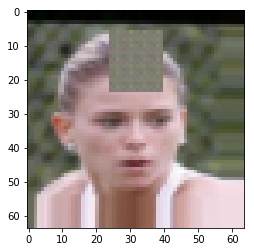

Step t [3] | Reconsturct Loss: [0.0070]
Step t [4] | Reconsturct Loss: [0.0074]
Done.


In [8]:
### Hyper-Parameters ###

args.train_step = 4
args.batch_size = 5
args.show_freq = 3
args.learning_rate = 0.001

# network.initialize_weights()

if not os.path.exists(args.model_path):
        os.makedirs(args.model_path)
        
epoch = 0
t = 1

### Strat Training ###
while t < args.train_step:
    
    for i, data in enumerate(training_loader): 
        if t < args.Tc:
            network.load_batch(data)
            network.zero_grad()
            network.first_step()
            if t % args.show_freq == 0:
                plt.figure()
                plt.imshow(img_fn(network.recon_img[0]))
                plt.show()
            print ("Step t [%d] | Reconsturct Loss: [%.4f]" % (t, network.recon_loss.item()))
 
        else:
            network.load_batch(data)
            network.zero_grad()
            network.second_step()
            if t % args.show_freq == 0:
                plt.figure()
                plt.imshow(img_fn(network.recon_img[0]))
                plt.show()
            print ("Step t [%d] | Discriminator Loss: [%.4f]" % (t, network.d_loss.item()))
    
            if t > args.Tc+args.Td:
                network.load_batch(data)
                network.zero_grad()
                network.third_step()
                print ("Step t [%d] | Discriminator Loss: [%.4f]" % (t, network.loss_all.item()))
        t += 1
        
        if t % args.save_freq == 0:
            model_path = "./Pytorch_Model/ImageCompletionStep"+str(t)+".pt"
            torch.save(network, model_path)
        
        if t > args.train_step:
            break
            
    if t < args.train_step:
        epoch += 1

print('Done.')